<a href="https://colab.research.google.com/github/bpizarrogalleguillos/bpizarrogalleguillos/blob/main/Image_captioning_exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Métodos Estadísticos 2
## Benjamín Pizarro
### 29/07/21



Los volúmenes crecientes de bases de datos médicos permite que técnicas de la ciencia de datos sean usadas a gran escala, permitiendo generar herramientas pronósticas, diagnósticas entre otras. A pesar de lo anterior, la información clínica es poco estructurada, presenta incosnsistencias, redundancia, ambiguedad, entre otros. Junto a lo anterior, la información es disgregada y puede ser incompleta.

En ese contexto, la radiología no es la excepción. En esta las bases de datos pueden ser incompletas, contando con reportes o no, contando con solo la impresión diagnóstica o en algunos casos solos los hallazgos, los cuales pueden estar o no etiquetados. De este modo contar con herramientas que permitan de forma automática etiquetar texto corresponden a herramientas de gran utilidad para aprocesar la información médica y posteriormente entrenar modelos.

El siguiente notebook, corresponde al trabajo final del curso procesamiento de lenguaje natural del magíster de informática médica. En este trabajamo se plantea como hipótesis de que es posible predecir la impresión diagnóstica final de una radiografía de tórax, es decir su normalidad o anormalidad, en base a los hallazgos médico de forma automatizada, utilizando embeddings y métodos de clasificación supervisados. Lo anterior es relevante, puesto que permitiría identificar radiografías con su hallazgos asociado que no cuenten con la impresion final, como patológicas o no, de forma automatizada.

Para esto se usó una base de datos correspondiente a las radiografías de tórax de la universidad de Indiana, las cuales se caracterizan por tener imágenes médicas asociadas a sus respectivos reportes. El dataset contiene 7000 imágenes de radiografías de 3500 pacientes, para los cuales se cuentan radiografías forntales y laterales, además de los respectivos reportes. Para los reportes se cuentan con términos MeSH, asi como si esta contiene hallazgos o no, la indicación diagnóstica, los hallazgos y las impresiones.

El trabajo se estructurará en dos partes, la primera de ellas corresponderá a un análisis exploratorio del corpus de los reportes, hallazgos e indicaciones de las radiografías. Se realizará un preprocesamiento por medio de expresiones regex, tokenizacion, extraccion de stop words, etc. Posteriormente se analizarán la frecuencia de las palabras, utilizando cumulative plots y nubes de palabras. Posteriormente se realizará el análisis de frecuencias de bigramas, trigramas y tetragramas, para comprender que oraciones se ocupan con mayor frecuencia. 

La segunda parte del trabajo, consistirá en generar vectores densos a partir del texto libre correspondiente a los hallazgos. Luego se representarán los embeddings usando PCA como técnica de reducción de dimensionalidad y visualización de datos. A partir de estos embeddings, se entrenaran un modelo de random forest, otro de regresión logistica y finalmente un Support Vector Machine. Se realizará una metodología clásica de entrenamiento, validación y testeo. 

Se espera, que el modelo logre una accuracy mayor al 80% para la clasificacion. 


In [ ]:
# En primer lugar vamos a instalar algunos paquetes

!pip install datasets
!pip install spacy
!pip install tokenizers
!pip install nltk
!pip intall bs4

     |████████████████████████████████| 542 kB 5.2 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
     |████████████████████████████████| 243 kB 41.1 MB/s 
     |████████████████████████████████| 118 kB 57.5 MB/s 
     |████████████████████████████████| 76 kB 4.0 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
     |████████████████████████████████| 3.3 MB 5.2 MB/s 
ERROR: unknown command "intall" - maybe you meant "install"


In [ ]:
# Importaremos las librerías necesarias para el modelo

import matplotlib.pyplot as plt
import  numpy as np
import pandas as pd
import os
import re
from tqdm import tqdm
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import nltk
nltk.download(['punkt','wordnet','gutenberg','webtext','stopwords'])
from nltk.util import ngrams
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

# Usaremos algunas de las librerias vistas en clases
import datasets # Biblioteca de manejo de conjuntos de datos para procesamiento de lenguaje natural
import spacy # Biblioteca de procesamiento de lenguaje natural
import tokenizers # Biblioteca de tokenización de texto
import gensim # Biblioteca de modelamiento de lenguaje
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import sklearn.decomposition
import plotly.express as px
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize


import gdown
import tarfile
import xml.dom.minidom
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image  
import tensorflow as tf
import cv2 as cv
from keras.models import load_model
from tensorflow.keras.applications import DenseNet121
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.backend import expand_dims
from tensorflow import concat
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import TimeDistributed
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,Layer,Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow import repeat
from sklearn.utils import shuffle
import nltk.translate.bleu_score as bleu

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Este código fue desarrollado para archivos XML de las imágenes correspondientes a las bases de datos de la Universidad de Indiana, permitiendo extraer informacion medica relevante.

In [ ]:
# En primer lugar accederemos a las imagenes guardadas y generaremos un 
# un dataframe, con información correspondiente a las imagenes, el hallazgo,
# y la indicación. 

indication_list=[]
finding_list=[]
impression_list=[]
image_list=[]
dir= "/content/drive/MyDrive/x-ray-captioning/ecgen-radiology" 
df=pd.DataFrame()

for file in tqdm(os.listdir("/content/drive/MyDrive/x-ray-captioning/ecgen-radiology")):
  if file.endswith(".xml"):
    file_name= str(dir) + "/" + str(file)
    tree=ET.parse(file_name)
    indication=tree.find(".//AbstractText[@Label='INDICATION']").text
    finding = tree.find(".//AbstractText[@Label='FINDINGS']").text
    impression = tree.find(".//AbstractText[@Label='IMPRESSION']").text
    indication_list.append(indication)
    finding_list.append(finding)
    impression_list.append(impression)
    image=set()
    for img in tree.findall("parentImage"):
      img_list = img.attrib['id']+".png"
      image.add(img_list)
    image_list.append(image)
    df=df.append(pd.Series([",".join(image)],index=["images"]),ignore_index=True)
df["indication"]=indication_list
df["finding"]=finding_list
df["impression"]=impression_list
df.to_csv("Extract_dataset.csv",index=False)

  0%|          | 0/3955 [00:00<?, ?it/s]

Verificamos que la información de los textos médicos haya sido cargada efectivamente. Visualizamos el nombre de la imagen, con su respectiva indicación, el hallazgo y la impresión diagnóóstica.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/x-ray-captioning/Extract_dataset.csv")
df

,images,indication,finding,impression
0,"CXR1007_IM-0008-1001.png,CXR1007_IM-0008-2001....",chest pain,Trachea is midline. The cardiomediastinal silh...,No acute cardiopulmonary abnormalities.
1,"CXR1000_IM-0003-2001.png,CXR1000_IM-0003-1001....","XXXX-year-old male, XXXX.",There is XXXX increased opacity within the rig...,1. Increased opacity in the right upper lobe w...
2,CXR1003_IM-0005-2002.png,Acute bronchitis.,Heart size and pulmonary vascularity appear wi...,1. Retrocardiac soft tissue density. The appea...
3,"CXR1004_IM-0005-1001.png,CXR1004_IM-0005-2001.png",XXXX-year-old with XXXX for one month. History...,"The heart, pulmonary XXXX and mediastinum are ...",No acute cardiopulmonary disease.
4,"CXR1005_IM-0006-1001.png,CXR1005_IM-0006-3003.png",Pruritic.,Cardiac and mediastinal contours are within no...,No acute findings.
...,...,...,...,...
3950,"CXR988_IM-2474-1001.png,CXR988_IM-2474-2001.png",Shortness of breath,Lungs are clear. No focal infiltrate. No pleur...,No active disease.
3951,"CXR991_IM-2476-2001.png,CXR991_IM-2476-1001.png",XXXX-year-old with pneumonia. Shortness of bre...,The heart size is upper limits of normal. The ...,Minimal perihilar opacity which could indicate...
3952,"CXR99_IM-2476-1002.png,CXR99_IM-2476-1001.png",XXXX-year-old with increasing dyspnea.,Normal heart and mediastinum. Clear lungs. Tra...,No acute abnormality.
3953,"CXR995_IM-2478-1002.png,CXR995_IM-2478-1001.png",SP CABG SOB NO RALES,Sternotomy sutures and bypass grafts have been...,Post operative chest with no acute disease.


Ahora preprocesaremos los datos y realizaremos el análisis exploratorio del texto libre

In [ ]:
extract_df = pd.read_csv("/content/drive/MyDrive/x-ray-captioning/Extract_dataset.csv")

# Imagenes perdidas
null = pd.isnull( extract_df["images"] )
df = extract_df[null]
print("Las imágenes perdidas corresponden a "+ str(len(df)) )

Las imágenes perdidas corresponden a 104


Ya sabemos que tenemos algunas imagenes que estan perdidas, veremos que pasa ahora con las indicaciones y las impresiones. En este caso, si no tenemos información, definiremos que el valor esta perdido, para esto tenemos que fijarnos que el texto puede decir sin indicacion o no indicar un valor. Junto a lo anterior tenemos que ser capaces de lidiar con todas las contracciones en el idioma ingles, esto es importante puesto que el valor de la negaciones relevante en el texto medico.

La siguiente celda define dos funciones una de ellas decontraction y la otra 
remove stopwords, la primera se encarga de normalizar las contracciones y otras expresiones que no aportan informacion relevante, la segunda remueve las stopwords y aplica la primera funcion descrita, además de tokenizar las palabras.

In [ ]:
def decontraction(doc):
    # Esto elimina las contracciones
    docs = re.sub(r"won't", "will not", doc)
    docs = re.sub(r"can\'t", "can not", docs)
    docs = re.sub(r"n\'t", " not", docs)
    docs = re.sub(r"\'re", " are", docs)
    docs = re.sub(r"\'s", " is", docs)
    docs = re.sub(r"\'d", " would", docs)
    docs = re.sub(r"\'ll", " will", docs)
    docs = re.sub(r"\'t", " not", docs)
    docs = re.sub(r"\'ve", " have", docs)
    docs = re.sub(r"\'m", " am",docs)
    docs = re.sub(r"n\'t", " not", docs)
    docs = re.sub(r"\'re", " are", docs)
    docs = re.sub(r"\'s", " is", docs)
    docs = re.sub(r"\'d", " would", docs)
    docs = re.sub(r"\'ll", " will", docs)
    docs = re.sub(r"\'t", " not", docs)
    docs = re.sub(r"\'ve", " have",docs)
    docs = re.sub(r"\'m", " am", docs)
    docs = re.sub(r"\*+", "abuse", docs)

    # Con esto elimino simbolos y elimino xxxx
    docs=re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]","",docs)# removing the special character in text
    docs=re.sub(r"xxxx","",docs)# Removing the irrelavent XXXX words
    docs=re.sub(r'xxx',"",docs)
    docs=re.sub(r'xx',"",docs)
    docs=re.sub(r'[0-9]',"",docs)# Removing the number in text
    docs = re.sub(r"yearold", "", docs)
    docs= re.sub('\s+',' ',docs)
    docs=re.sub("'",'',docs)# Removing apoustahe
    docs=re.sub(r'\.\.+', '.',docs)# Removing multiple full stop
    docs=re.sub(r'  ',"",docs)
    return docs

def remove_stopwords(data):
  # remuevo las stopwrods
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')# removing the "not" from the stopwords
  all_stopwords.remove('no')

  # tokenizo y elimino stopwrods
  text_tokens = word_tokenize(data) # tokenizing the sentence into word
  tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
  return " ".join(tokens_without_sw)

In [ ]:
# Aca voy a plicar las funciones definidas previamente sobre las impresiones
# hallazgos e indicaciones

col = ["indication", "finding", "impression"]

for j in col:
  for i in range(len(extract_df[j])):
    extract_df[j][i] = str(extract_df[j][i]).lower()
    text = extract_df[j][i]
    text = re.sub(r'[^A-Za-zñáéíóú]', ' ', text)
    text = decontraction(text)
    text = remove_stopwords(text)
    extract_df[j][i] = text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning:

Possible set union at position 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning:

Possible set union at position 8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning:

Possible set union at position 21



Ahora tenemos nuestra base de datos con el texto preprocesado, en el cual eliminamos caracteres irrelevantes, llevamos todo a minusculas, eliminamo espacios, etc.

In [ ]:
extract_df.to_csv("Processed_extract_dataset.csv",index=False)

In [ ]:
clean = pd.read_csv("Processed_extract_dataset.csv")
clean["impression"][0:5]

0               no acute cardiopulmonary abnormalities
1    increased opacity right upper lobe associated ...
2    retrocardiac soft tissue density appearance su...
3                     no acute cardiopulmonary disease
4                                    no acute findings
Name: impression, dtype: object

## Análisis exploratorio de los datos


La siguiente funcion nos muestra como es la relacion entre la indicacion para realizar los examens, cuantos son unicos y cuantos son reptidos. Esto puede ser posible debido a que hay indicaciones estandard tales como "dolor de pecho". 

In [ ]:
indication_reports=pd.Series(extract_df["indication"].tolist())
len_indication=len(indication_reports)
unique_indication_report=len(np.unique(indication_reports))
print("no. of unique indication report in the dataset:{}".format(unique_indication_report))
repeated_indication_report=np.sum(indication_reports.value_counts()>1)
print("No. of indication report repeated more than one times:{}".format(repeated_indication_report))

no. of unique indication report in the dataset:2024
No. of indication report repeated more than one times:216


Se instalara una version específica de matplotlib para realizar los cumulative plots

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.2.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.2.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib.libs/libpng16-cfdb1654.so.16.21.0
    /usr/local/lib/python3.7/dist-packages/matplotlib.libs/libz-a147dcb0.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
y
  Successfully uninstalled matplotlib-3.2.2
     |████████████████████████████████| 13.1 MB 87 kB/s 
ERROR: pip's dependency r

### Indicaciones

En las siguientes celdas usaremos gráficos cumulativos así como también nubes de palabras para buscar relaciones entre las indicaciones de las radiografías, en otras palabras el motivo por el cual se solicitó el examen.

Realizamos un gráfico cumulativo donde podemos observar cuales son las indicaciones más frecuentes para realizar el estudio dentro de las cuales encontramos que el dolor de pecho, disnea, dificultad respiratoria, dolor son las palabras más frecuentes.

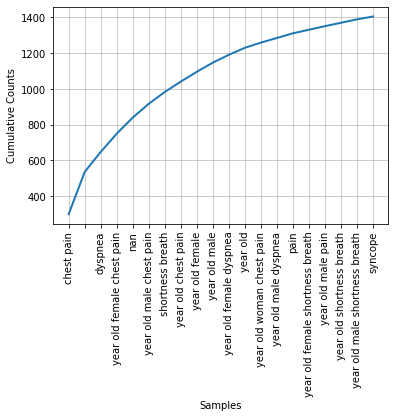

In [ ]:
fdist = nltk.FreqDist(extract_df["indication"])
fdist.plot(20, cumulative=True)

In [ ]:
ind = indication_reports.to_list()

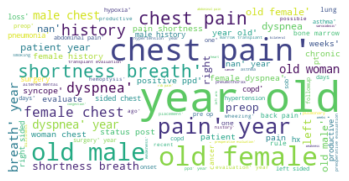

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(ind))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Vamos a eliminar la palabra years old, ya que no nos esta aportando mucha informacion, nos daremos cuenta de que los terminos que más aparecen corresponden a los anteriormente nombrados

In [ ]:
ind =re.sub(r'year',"",str(ind))
ind =re.sub(r'old',"",str(ind))

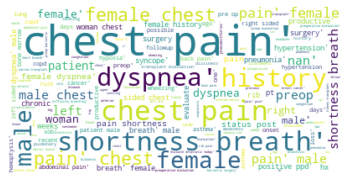

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(str(ind))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Hallazgos e impresión diagnóstica


Ahora repetiremos esto para los hallazgos mas frecuentes y para la impresion diagnostica. En otras palabras los hallazgos corresponderían a la descripción de la imagen por el radiólogo, mientras que la impresión correspondería a las conclusiones del estudio. 

Interesantemente podemos ver como una de las palabras relevantes corresponden a nomal. Lo cual es esperable pues es el hallazgo más frecuente frente a la consulta de dolor de pecho. Ademas es frecuente que se describan las estructuras normales en un informe radiologico descartando potenciales patologias.

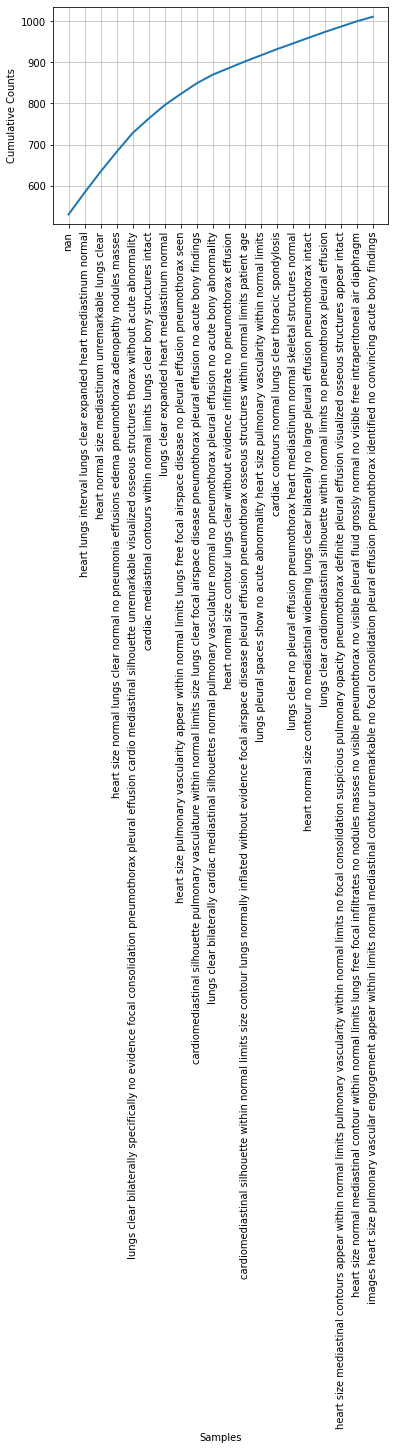

In [260]:
fdist = nltk.FreqDist(extract_df["finding"])
fdist.plot(20, cumulative=True)

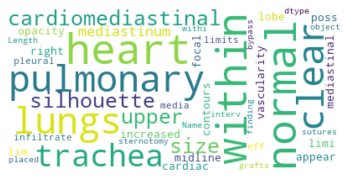

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(str(extract_df["finding"]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Ahora bien podemos usar las palabra sque mas se repiten, y podemos encontrar lo siguiente. Aparecen palabras como efusion, pneumotorax, normal, consolidacion. Las cuales son palabras esperables

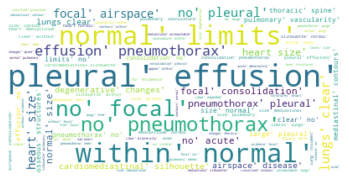

In [ ]:
fin = extract_df["finding"].tolist()
fin = word_tokenize(str(fin))
fdist = nltk.FreqDist(str(fin))


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(fin))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Impresiones diagnósticas

Con respecto a las impresiones diagnósticas, destacan algunas palabras acomo agudas, indicando cambios recientes de alguna patologia, anormalidades, opacidad. Esta última corresponde a un hallazgo relevante en el diagnostico de neumonía, derrames pleurales, atelectasias entre otros. El resto de las palabras corresponden a descripciones de la ubicacion de algunas de los hallazgos que se describen habitualmente en las radiografias. 

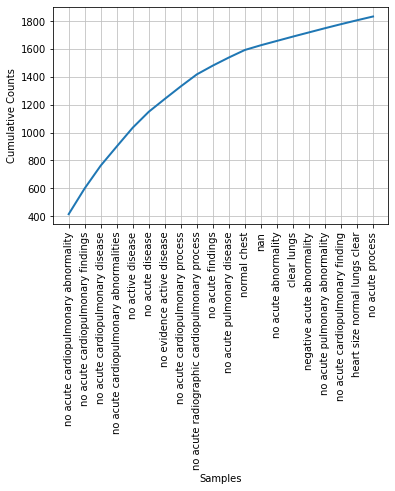

In [261]:
fdist = nltk.FreqDist(extract_df["impression"])
fdist.plot(20, cumulative=True)

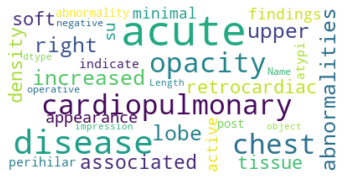

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(str(extract_df["impression"]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

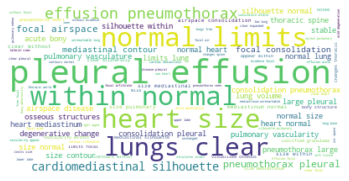

In [ ]:
imp = extract_df["impression"].tolist()
imp = word_tokenize(str(fin))
fdist = nltk.FreqDist(str(imp))


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(imp))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Podemos observar como entre las indicaciones más frecuentes para una radiografía de tórax, corresponden a al dolor de pecho, la disnea y la dificultad repiratoria, lo cual es esperable. Además es interesante ver como los hallazgos en general tienden a ser normales, sin embargo destaca que existen diversas formas de describir dicha normalidad. Finalmente podemos concluir que un número importante de estudios se reportan como normales, aunque destacan algunos términos como pneumothorax, pleural efussiuon y opacidades, que corresponden a patologías relativamente frecuentes.

## Analisis de n-gramas

Se realizó un análisis de n-grams, para las indicaciones, los hallazgos e impresiones. Con esto podemos observar algunas oraciones más largas, en general, no se encontro combinaciones muy relevantes, dado que en general los hallazgos en radiografías tienden a ser normales. Junto a lo anterior incluso teniendo una patología, como una condensación por neumonía, el resto de los hallazgos, serán normales, lo cual es descrito como ausencia de derrame o efussion, sin pneumotórax, etc.


In [ ]:


# definimos la funcion get_top_ngrams 
# que permite obtener los n-gramas deseados

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

### Bigramas

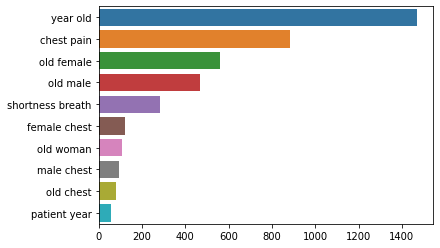

In [ ]:
top_n_bigrams=get_top_ngram(extract_df["indication"],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x) 

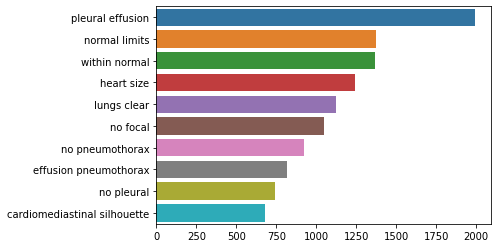

In [ ]:
top_n_bigrams=get_top_ngram(extract_df["finding"],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x) 

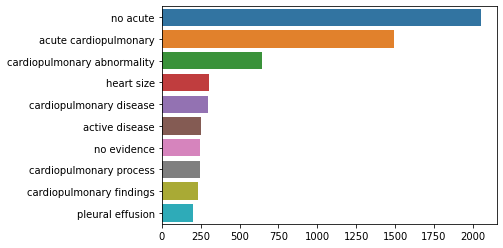

In [ ]:

top_n_bigrams=get_top_ngram(extract_df["impression"],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x) 

## Analisis de trigramas

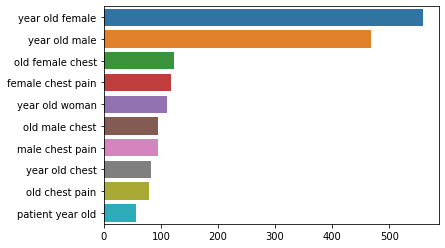

In [ ]:
top_n_bigrams=get_top_ngram(extract_df["indication"],3)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x) 

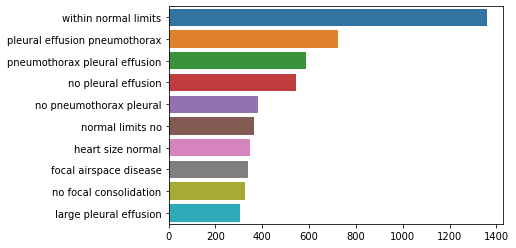

In [ ]:
top_n_bigrams=get_top_ngram(extract_df["finding"],3)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x) 

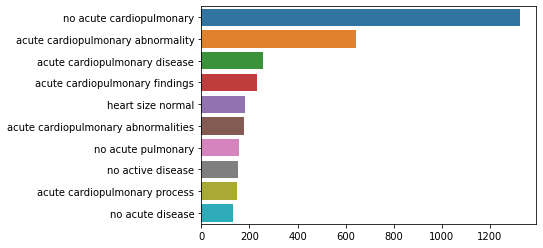

In [ ]:
top_n_bigrams=get_top_ngram(extract_df["impression"],3)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x) 

## Tetragramas

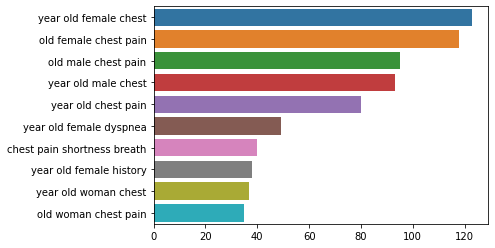

In [ ]:
top_n_bigrams=get_top_ngram(extract_df["indication"],4)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x) 

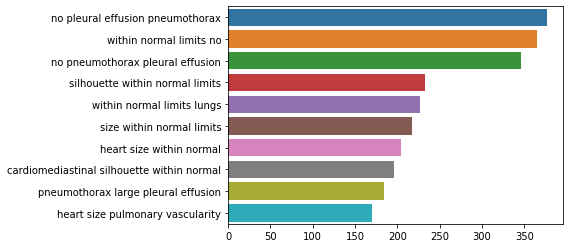

In [ ]:
top_n_bigrams=get_top_ngram(extract_df["finding"],4)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x) 

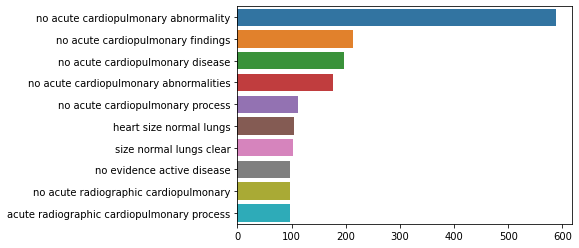

In [ ]:
top_n_bigrams=get_top_ngram(extract_df["impression"],4)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x) 

Los análisis de n-gramas previos, demuestran información relativamente similar a la que se observo en las nubes de palabras y los gráficos cumulativos.

## Embeddings

En la siguiente sección generaremos embeddings de las palabras usadas, para esto generaremos un vocabulario y posteriormente generaremos los vectores densos para este vocabulario

In [ ]:
#Load the pre processed report findings from the pickle file.
df = pd.read_csv("/content/drive/MyDrive/x-ray-captioning/Processed_extract_dataset.csv")
first_sent = pd.DataFrame(df["impression"])
indication_sent = pd.DataFrame(df["indication"])
finding_sent = pd.DataFrame(df["finding"])
df

,images,indication,finding,impression
0,"CXR1007_IM-0008-1001.png,CXR1007_IM-0008-2001....",chest pain,trachea midline cardiomediastinal silhouette n...,no acute cardiopulmonary abnormalities
1,"CXR1000_IM-0003-2001.png,CXR1000_IM-0003-1001....",year old male,increased opacity within right upper lobe poss...,increased opacity right upper lobe associated ...
2,CXR1003_IM-0005-2002.png,acute bronchitis,heart size pulmonary vascularity appear within...,retrocardiac soft tissue density appearance su...
3,"CXR1004_IM-0005-1001.png,CXR1004_IM-0005-2001.png",year old one month history bronchitis,heart pulmonary mediastinum within normal limi...,no acute cardiopulmonary disease
4,"CXR1005_IM-0006-1001.png,CXR1005_IM-0006-3003.png",pruritic,cardiac mediastinal contours within normal lim...,no acute findings
...,...,...,...,...
3950,"CXR988_IM-2474-1001.png,CXR988_IM-2474-2001.png",shortness breath,lungs clear no focal infiltrate no pleural eff...,no active disease
3951,"CXR991_IM-2476-2001.png,CXR991_IM-2476-1001.png",year old pneumonia shortness breath,heart size upper limits normal pulmonary media...,minimal perihilar opacity could indicate atypi...
3952,"CXR99_IM-2476-1002.png,CXR99_IM-2476-1001.png",year old increasing dyspnea,normal heart mediastinum clear lungs trachea m...,no acute abnormality
3953,"CXR995_IM-2478-1002.png,CXR995_IM-2478-1001.png",sp cabg sob no rales,sternotomy sutures bypass grafts placed interv...,post operative chest no acute disease


In [ ]:
words_imp = word_tokenize(str(df["impression"].to_list()))
words_ind = word_tokenize(str(df["indication"].to_list()))
words_fin = word_tokenize(str(df["finding"].to_list()))

In [ ]:
# Observamos la cantidad de palabras para las impresiones, indicaciones
# y los hallazgos

tokenizer = Tokenizer(oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(words_imp)

tokenizer1 = Tokenizer(oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer1.fit_on_texts(words_ind)

tokenizer2 = Tokenizer(oov_token="<unk>",filters='!"#$%&\'()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer2.fit_on_texts(words_fin)

max_len_output = len(tokenizer.word_index) +1
print(max_len_output)

max_len_output = len(tokenizer1.word_index) +1
print(max_len_output)

max_len_output = len(tokenizer2.word_index) +1
print(max_len_output)

1622
1455
1519


### Word2Vec

In [ ]:
# Usaremos Word2Vec para generar los embeddigns

import gensim

fin_token = []
for i in range(len(fin)):
  fin_token.append(word_tokenize(str(fin[i])))

In [ ]:
# define training data
sentences = fin_token

# train model
model =  gensim.models.Word2Vec(sentences, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)

# save model
model.save('model.bin')

Word2Vec(vocab=1695, size=100, alpha=0.025)
['[', "'trachea", 'midline', 'cardiomediastinal', 'silhouette', 'normal', 'lungs', 'clear', 'without', 'evidence', 'acute', 'infiltrate', 'effusion', 'no', 'pneumothorax', 'visualized', 'bony', 'structures', 'show', 'abnormalities', 'lateral', 'view', 'reveals', 'mild', 'degenerative', 'changes', 'thoracic', 'spine', "'", ',', "'increased", 'opacity', 'within', 'right', 'upper', 'lobe', 'possible', 'mass', 'associated', 'area', 'atelectasis', 'focal', 'consolidation', 'cardiac', 'limits', 'left', 'midlung', 'overlying', 'posterior', 'th', 'rib', 'may', 'represent', 'airspace', 'disease', 'pleural', 'bone', 'abnormality', "'heart", 'size', 'pulmonary', 'vascularity', 'appear', 'retrocardiac', 'soft', 'tissue', 'density', 'present', 'appears', 'air', 'could', 'suggest', 'represents', 'hiatal', 'hernia', 'vascular', 'calcification', 'noted', 'calcified', 'granuloma', 'seen', 'interval', 'development', 'bandlike', 'lung', 'base', 'osteopenia', 'm

Para observar si nuestro embeddings funcionó vamos a imprimir el vector dednso para la palabra "increased"

In [ ]:
# access vector for one word
print(model['increased'])

[ 8.0228585e-04 -1.2716812e-03  4.7035418e-03  1.0290383e-03
 -3.0748113e-03  3.6913488e-04  4.1163564e-03 -3.4510784e-03
 -1.3738156e-04  4.6520568e-03  3.4493967e-03 -2.9692608e-03
 -4.1569467e-04 -7.6152623e-04 -2.4834170e-03  1.4474413e-03
  4.9730395e-03 -3.4351246e-03 -7.2392122e-06 -8.0785877e-04
 -4.3689394e-03 -1.5547288e-03  1.6077665e-03 -8.1849069e-04
 -2.8250122e-03 -1.5368195e-03 -2.9409304e-03  6.5639411e-04
 -2.7567428e-03  3.8199006e-03  1.2258545e-03 -3.5019179e-03
 -3.7061204e-03 -3.0023855e-04  1.2075873e-03  1.4370222e-03
  6.7745679e-04 -6.3654489e-04  1.9490649e-03 -4.1377852e-03
 -1.0953266e-03  3.1936746e-03  2.2730411e-03 -1.7284199e-04
  2.4681571e-03 -4.3991185e-03  4.1112495e-03 -1.7533778e-03
  1.5572273e-03  1.1510062e-03 -1.7064773e-03  4.1311122e-03
  1.4942990e-05 -2.8434368e-03 -2.8007277e-03  1.0701214e-03
  4.0860199e-03 -2.1832963e-03  1.9404838e-03  4.5664795e-04
  4.5151785e-03  2.5366459e-03 -1.7867585e-03  2.3351384e-03
 -4.2574825e-03  3.32858

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



Junto a lo anterior observaremos cuales son las palabras cercanas a "acute", "mass" y "opacity"

In [ ]:
model.wv.most_similar("acute")

[('diaphragmatic', 0.41870757937431335),
 ('remain', 0.3137128949165344),
 ('soft', 0.3086535632610321),
 ('fusion', 0.2966981530189514),
 ('unilateral', 0.2745368480682373),
 ('suggestion', 0.26793622970581055),
 ('collapse', 0.267384797334671),
 ('cell', 0.2637786865234375),
 ('image', 0.26120370626449585),
 ('configuration', 0.2598516047000885)]

In [263]:
model.wv.most_similar("mass")

[('osteopenic', 0.3103427290916443),
 ('bacterial', 0.3048053979873657),
 ("'nodular", 0.28774139285087585),
 ('cardiothoracic', 0.286159873008728),
 ("'strandy", 0.27775442600250244),
 ('cervicothoracic', 0.2688238024711609),
 ('crowded', 0.2628532648086548),
 ('examination', 0.25606897473335266),
 ('sequelae', 0.25296729803085327),
 ('levocurvature', 0.2514096796512604)]

In [264]:
model.wv.most_similar("opacity")

[('definitive', 0.33306512236595154),
 ('multiple', 0.2954155206680298),
 ('separation', 0.2915767431259155),
 ('spasm', 0.2653614282608032),
 ('hydropneumothorax', 0.2641787827014923),
 ('systems', 0.2576058804988861),
 ('compartment', 0.2531343698501587),
 ('cell', 0.2489989995956421),
 ('kyphosis', 0.24236509203910828),
 ('costodiaphragmatic', 0.24081188440322876)]

En las siguientes líneas de código se ejemplifica como las palabras normal y otras asociada a patologías se aprecian bastantes distintas.

In [273]:
pairs = [
    ('normal', 'limits'), 
    ('normal', 'opacity'),
    ('normal', 'mass'),
    ('normal', 'consolidation'),
    ('normal', 'lesion')
]

In [274]:
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, model.wv.similarity(w1, w2)))

'normal'	'limits'	0.12
'normal'	'opacity'	-0.06
'normal'	'mass'	-0.06
'normal'	'consolidation'	0.27
'normal'	'lesion'	-0.01


### Representacion de baja dimensionalidad

Interesantemente cunado hacemos la proyección de los embeddings, podemos observar que estos no presentan clusters muy característicos, por lo que es posible que usar solo dos dimensiones no sea lo suficientemente necesario para poder graficar las diferencias entre los embeddings

In [ ]:
projector = sklearn.decomposition.PCA(3)
vectors_2d = projector.fit_transform(model.wv.vectors)[:,:2]
fig = px.scatter(
    x=vectors_2d[:,0],
    y=vectors_2d[:,1],
    text=model.wv.index2word
)
fig.update_traces(mode="markers")

# Clasificacion

Para la parte final, importaremos otro archivo en el cual se identifican, si las radiografías son normales o tienen "problemas", volveremos a normalizar los datos, junto a lo anterior vamos a generar dos nuevas columnas una para codificar los problemas en anormales y normales. Junto a esto crearemos representaciones densas de los hallazgos por medio de la suma y posterior normalización de cada una de las palabras que la componen.

In [126]:
# Dentro del dataset se encuentra otro csv en el que se indican si las
# radiografías son normales o anormales según términos mesh

normal = pd.read_csv("/content/drive/MyDrive/x-ray-captioning/indiana_reports.csv")

abnormal = []
for i in normal["Problems"]:
  if i == "normal":
    abnormal.append(0)
  else:
    abnormal.append(1)

In [127]:
normal

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.
...,...,...,...,...,...,...,...,...
3846,3995,Lung/hyperdistention/mild;Diaphragm/bilateral/...,Lung;Diaphragm;Cicatrix;Pulmonary Atelectasis;...,Xray Chest PA and Lateral,"Nausea, vomiting x2 weeks. Dialysis patient.","XXXX, XXXX.",The cardiomediastinal silhouette and pulmonary...,1. Interval resolution of bibasilar airspace d...
3847,3996,Spine/degenerative,Spine,Xray Chest PA and Lateral,NaN,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...
3848,3997,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,XXXX-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB."
3849,3998,normal,normal,"PA and lateral chest XXXX, XXXX XXXX comparis...",tuberculosis positive PPD,NaN,NaN,Heart size is normal and the lungs are clear.


In [128]:

# Aca voy a plicar las funciones definidas previamente sobre las impresiones
# hallazgos e indicaciones, de forma que sean preprocesadas

col = ["indication", "findings", "impression", "Problems", "MeSH"]

for j in col:
  for i in range(len(normal[j])):
    normal[j][i] = str(normal[j][i]).lower()
    text = normal[j][i]
    text = re.sub(r'[^A-Za-zñáéíóú"]', ' ', text)
    text = decontraction(text)
    text = remove_stopwords(text)
    normal[j][i] = text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [166]:
normal["ab"] = abnormal
normal = normal.dropna(subset=["findings"])
normal

,uid,MeSH,Problems,image,indication,comparison,findings,impression,ab,finding_vector
0,1,normal,normal,Xray Chest PA and Lateral,positive tb test,None.,cardiac silhouette mediastinum size within nor...,normal chest x,0,"[-0.014381248709186483, -0.09961780572383871, ..."
1,2,cardiomegaly borderline pulmonary artery enlarged,cardiomegaly pulmonary artery,"Chest, 2 views, frontal and lateral",preop bariatric surgery,None.,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings,1,"[0.023454191504483583, -0.12627959931314933, 0..."
3,4,pulmonary disease chronic obstructive bullous ...,pulmonary disease chronic obstructive bullous ...,"PA and lateral views of the chest XXXX, XXXX a...",year old,None available,diffuse bilateral interstitial alveolar opacit...,bullous emphysema interstitial fibrosis probab...,1,"[-0.004684983649105724, -0.09136121807358284, ..."
4,5,osteophyte thoracic vertebrae multiple small t...,osteophyte thickening lung,Xray Chest PA and Lateral,chest nasal congestion,None available,cardiomediastinal silhouette pulmonary vascula...,no acute cardiopulmonary abnormality,1,"[-0.023939730392854353, -0.0849772599359553, 0..."
5,6,normal,normal,"PA and Lateral Chest. XXXX, XXXX at XXXX",evaluate infection,"XXXX, XXXX",heart size mediastinal contour within normal l...,no acute cardiopulmonary findings,0,"[-0.034438546166549885, -0.07726504582217976, ..."
...,...,...,...,...,...,...,...,...,...,...
3844,3993,cardiomegaly mild diaphragm left elevated,cardiomegaly diaphragm,CHEST 2V FRONTAL/LATERAL,edema,None,heart mildly enlarged left hemidiaphragm eleva...,borderline cardiomegaly without acute disease,1,"[0.012784530732681699, -0.1201977905041195, 0...."
3845,3994,cardiomegaly mild pulmonary congestion heart f...,cardiomegaly pulmonary congestion heart failure,2 view ( PA and lateral) chest radiograph date...,year old male chest pain positive troponin,"Portable chest x-XXXX XXXX, XXXX",similar mild cardiomegaly pulmonary vascularit...,mild cardiomegaly early failure,1,"[0.012072233204535118, -0.10121965215937899, 0..."
3846,3995,lung hyperdistention mild diaphragm bilateral ...,lung diaphragm cicatrix pulmonary atelectasis ...,Xray Chest PA and Lateral,nausea vomiting x weeks dialysis patient,"XXXX, XXXX.",cardiomediastinal silhouette pulmonary vascula...,interval resolution bibasilar airspace disease...,1,"[-0.00728488852446219, -0.09473886136290993, 0..."
3847,3996,spine degenerative,spine,Xray Chest PA and Lateral,NaN,None.,lungs clear heart size normal no pneumothorax ...,clear lungs no acute cardiopulmonary abnormality,1,"[-0.03861868979803962, -0.0666626427197862, 0...."


In [167]:
def to_vector(tokens,model):
    """ Receives a sentence string along with a word embedding model and 
    returns the vector representation of the sentence"""
    vec = np.zeros(model.wv.vectors.shape[1]) # creates an empty vector of 300 dimensions
    for word in tokens: # iterates over the sentence
        if word in model: # checks if the word is both in the word embedding and the tf-idf model
            vec += model[word] # adds every word embedding to the vector
    if np.linalg.norm(vec) > 0:
        return vec / np.linalg.norm(vec) # divides the vector by their normal
    else:
        return vec

In [168]:
sentence_vector = []
for i in range(len(normal["findings"])):
  vec = to_vector(str(normal.iloc[i,6]), model)
  sentence_vector.append(vec)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [169]:
normal["finding_vector"] = sentence_vector

In [170]:
normal = normal.replace('nan', np.NaN)

/usr/local/lib/python3.7/dist-packages/pandas/core/missing.py:49: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Ahora vamos a dividir en conjunto de entrenamiento, validacion y testeo. 

In [219]:
arr = []
for i in normal["finding_vector"]:
  a = np.array(i).reshape(100)
  arr.append(a)
np.array(arr).shape

findings_final = pd.DataFrame(np.array(arr))
impression_final = normal.iloc[:,8]

# Dividimos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(
    findings_final, impression_final, test_size=0.10, random_state=42)

# Dividimos en entrenamiento y validacion
X_train, X_validation, y_train, y_validation = train_test_split(
    findings_final, impression_final, test_size=0.10, random_state=42)

# Verificamos las dimensiones de los datsets
print(X_train.shape, X_validation.shape, X_test.shape)

# Verificamos las dimensiones de los datsets
print(y_train.shape, y_validation.shape, y_test.shape)

(3003, 100) (334, 100) (334, 100)
(3003,) (334,) (334,)


In [220]:
X_train[0]

2905    0.003888
3191   -0.009484
1225    0.005365
1272   -0.002367
1442   -0.002134
          ...   
1095   -0.036819
1130    0.017672
1294   -0.008002
860     0.024872
3174   -0.017474
Name: 0, Length: 3003, dtype: float64

In [221]:
y_train

3342    1
3675    1
1403    1
1456    1
1643    1
       ..
1250    1
1293    1
1478    0
980     1
3656    1
Name: ab, Length: 3003, dtype: int64

# Prediccion

En esta seccion usaremos tres modelos los cuales seran testeados en el conjunto de validacion. Posteriormente, elegiremos el mejor modelo para poder hacer un fine tuning y luego testear.

### Random Forest

In [226]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train.values, y_train.values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [227]:
print( (sklearn.metrics.classification_report(
    y_validation,
    clf.predict(X_validation)) ))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       115
           1       0.86      0.92      0.89       219

    accuracy                           0.85       334
   macro avg       0.84      0.82      0.83       334
weighted avg       0.85      0.85      0.85       334



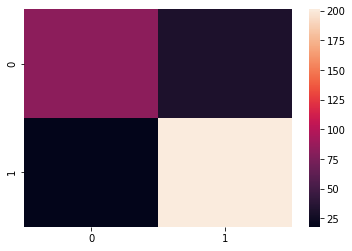

In [228]:
from sklearn.metrics import confusion_matrix
y_pred =  clf.predict(X_validation)
cr = confusion_matrix(y_validation, y_pred)
sns.heatmap(cr)

### Usando regresión logistica

In [229]:
classifier = sklearn.linear_model.LogisticRegression(solver='liblinear')
classifier.fit(X_train, y_train)

print( (sklearn.metrics.classification_report(
    y_validation,
    classifier.predict(X_validation)) ))

              precision    recall  f1-score   support

           0       0.59      0.17      0.26       115
           1       0.68      0.94      0.79       219

    accuracy                           0.67       334
   macro avg       0.64      0.55      0.52       334
weighted avg       0.65      0.67      0.61       334



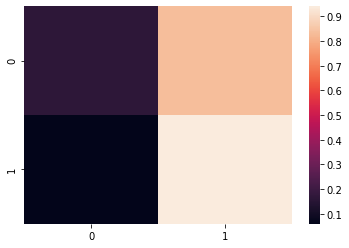

In [230]:
y_pred =  classifier.predict(X_validation)
cr = confusion_matrix(y_validation, y_pred,  normalize="true")
sns.heatmap(cr)

### SVM

In [232]:
from sklearn import svm
X = X_train
Y = y_train
clf_svm = svm.SVC(decision_function_shape='ovo')
clf_svm.fit(X, Y)

print( (sklearn.metrics.classification_report(
    y_validation,
    clf_svm.predict(X_validation)) ))


              precision    recall  f1-score   support

           0       0.66      0.20      0.31       115
           1       0.69      0.95      0.80       219

    accuracy                           0.69       334
   macro avg       0.67      0.57      0.55       334
weighted avg       0.68      0.69      0.63       334



### Optimizando

Como podemos ver random Forest es el modelo que mejor resultado obtuvo, ahora intentaremos ajustar sus parámetros.

In [245]:
n_estimators = [100, 300]
max_depth = [5, 8, 15, 25]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 5] 

forest = RandomForestClassifier()

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF)

bestF = gridF.fit(X_validation, y_validation)

In [247]:
bestF.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [254]:
best_random = bestF.best_estimator_

print( (sklearn.metrics.classification_report(
    y_validation,
    best_random.predict(X_validation)) ))


              precision    recall  f1-score   support

           0       0.96      0.93      0.94       115
           1       0.96      0.98      0.97       219

    accuracy                           0.96       334
   macro avg       0.96      0.95      0.96       334
weighted avg       0.96      0.96      0.96       334



## Testeo final

Ahora usaremos nuestro modelo optimizado en el conjunto final

In [255]:
print( (sklearn.metrics.classification_report(
    y_test,
    best_random.predict(X_test)) ))


              precision    recall  f1-score   support

           0       0.96      0.93      0.94       115
           1       0.96      0.98      0.97       219

    accuracy                           0.96       334
   macro avg       0.96      0.95      0.96       334
weighted avg       0.96      0.96      0.96       334



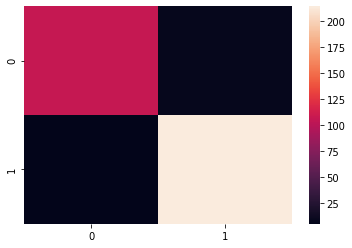

In [256]:
cr = confusion_matrix(y_test, best_random.predict(X_test))
sns.heatmap(cr)

Podemos observar como posterior a la optimizaciónd e hiper parámetros podemos encontrar un modelo con la capacidad de clasificar con alta sensibilidad y especificidad si un reporte es anormal o normal en base a un vector denso de  los hallazgos descritos por un radiólogo

# Conclusiones

En este trabajo pudimos realizar un análisis exploratorio y predictivo en torno a la hipótesis de que a partir de los hallazgos diagnósticos de reportes radiológicos es posible predecir si la impresión diagnóstica corresponderá a una radiografía normal o anormal.

Para esto, como primer paso normalizamos los datos usando diversas estrategias, incluidas, regex, tokenizaciones y stopwords. Posteriormente se realizó una análisis exploratorio de los datos, destacando que un gran número de reportes eran normales. Se crearon embeddings de palabras y se entrenarom modelos para predecir si los hallazgos codificados como vectores densos, podían permitir clasificar si un reporte finalmente indicaría condiciones patológicas o no.

Junto a lo anterior, es importante destacar como distintos modelos se comportaron de forma distinta, destacando la necesidad de evaluar diversos modelos frente a una misma tarea. Junto a lo anterior es llamativo el buen rendimiento del modelo posterior a la optimización de parámetros, no obstante, no se realizó validación cruzada debido a la falta de poder de computo.

En conclusión a lo largo de este ejercicio se pudo observar como se comprobo la hipotesis propuesta inicialmente. Como posibles caminos a futuro, sería interesante analizar, si es posible determinar con exactitud, cuál es el hallazgo patológico con exactitud, sin embargo otros enfoques, probablemente usando redes recurrentes deban ser necesarios. 